In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from env import get_db_url
import wrangle
from statistics import stdev
from sklearn.model_selection import train_test_split
from itertools import combinations, product, permutations
from statistics import stdev

### Acquire
- Looking at the dataset in SQL, many columns were missing data or had erroneous information.
- Zip code was not chose due to having county information via fips.
- Tax_Assessed was pulled to determine the tax rate but will not be used in modeling.

In [2]:
df = wrangle.get_zillow_data()

### Prepare
  
   - Data cleaning:
   - drop nulls
   - County Code(convert to County names)
   - convert floats to integers except for Number_of_Bedrooms
   
   
   - Determine what a "home" should be considered in terms of beds, baths, square feet.
       - The data has been updated to include only home with greater than 1 bed, 1 bath, and a minimum of 120 sq. ft.
   - Tax Appraised vs Tax Asseses (drop Tax Assesed)
  
   - Outliers:
   - Approximately 5% of data dropped to exclude extreme outliers.
   - Values are:
       - 7 Beds
       - 7.5 Baths
       - 10,000 or less sq. feet
       - 20,000 or less sq. feet (lot size)
       - $3.5M or less in appraised value
   


In [5]:
df = wrangle.prepare_zillow_data(df)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Number_of_Bedrooms,2123966.0,3.308068,0.919100,1.00,3.00,3.000,4.00,2.500000e+01
Number_of_Bathrooms,2123966.0,2.241499,0.981043,1.00,2.00,2.000,3.00,3.200000e+01
Square_Feet,2123966.0,1861.543512,1158.960971,127.00,1260.00,1623.000,2206.00,9.525760e+05
Tax_Appraised_Value,2123966.0,459110.621375,666833.569081,23.00,189432.00,328132.000,533299.00,9.018846e+07
Year_Built,2123966.0,1960.869213,22.014132,1801.00,1949.00,1958.000,1975.00,2.016000e+03
Tax_Assessed,2123966.0,5594.591086,7686.866621,16.48,2544.19,4109.545,6395.74,1.078102e+06
Lot_Size,2123966.0,10666.656294,264924.354940,104.00,5638.00,6757.000,8527.00,3.710005e+08
Tax_Rate,2123966.0,1.322178,1.839770,0.00,1.17,1.240,1.36,1.859170e+03


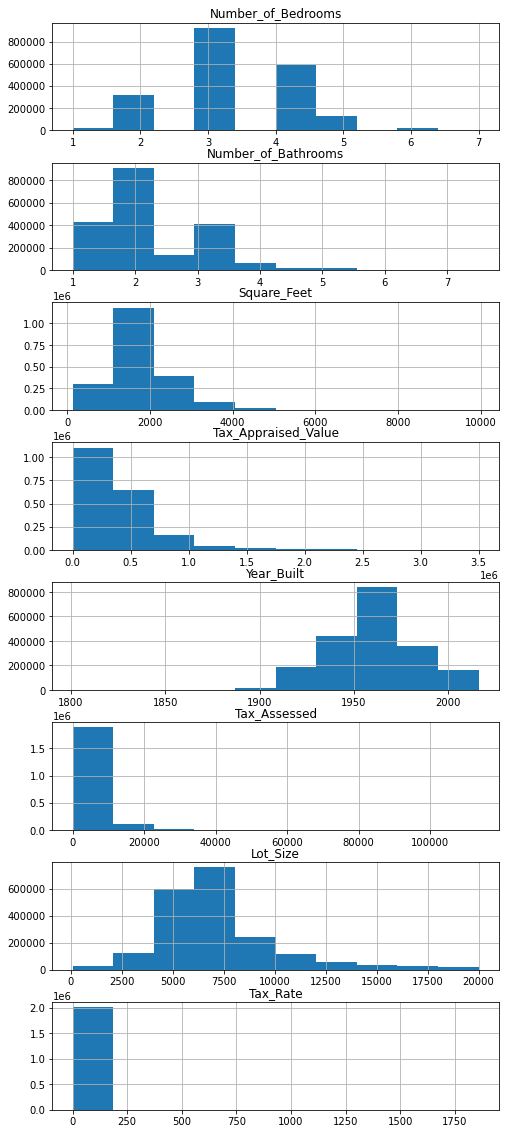

In [16]:
fig, axis = plt.subplots(8,1,figsize=(8, 20))
df.hist(ax=axis)
plt.show()

**Handling outliers**
The majority of customers are not going to be purchasing exorbitant homes.
   - Dataset adjusted to remove outliers.
   - Max bath = 7.5, max bed = 7, max appraised value = 3.5M, max sq. feet = 10,000, max lot size = 20,000

In [8]:
# removing signifcant outliers leaves ~94% of data.
df[(df.Tax_Appraised_Value>3_500_000) | (df.Number_of_Bathrooms >7.5) | (df.Number_of_Bedrooms >7) | (df.Square_Feet >10000) | (df.Lot_Size>20000)].shape[0]/ df.shape[0]

0.055193915533487826

In [10]:
df = wrangle.handle_outliers(df)

In [11]:
df.head()

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Feet,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,Lot_Size,Tax_Rate
4,4,2.0,3633,296425,2005,6941.39,Los Angeles,9826,2.34
7,3,2.0,2077,646760,1926,7924.68,Los Angeles,6490,1.23
18,3,1.0,1244,169471,1950,2532.88,Los Angeles,6021,1.49
19,3,2.0,1300,233266,1950,3110.99,Los Angeles,4917,1.33
20,3,2.0,1222,290492,1951,3870.25,Los Angeles,5500,1.33


### Explore

    - Questions to answer:
        - How does bed, bath, square feet relate to tax value? Add lot size, with time.
        - Does year built affect the tax value?
        - What does county, tax rate have to do with value?
        

In [17]:
train, validate, test = wrangle.split_zillow_data(df)
# split into train, validate, test before exploration

<AxesSubplot:>

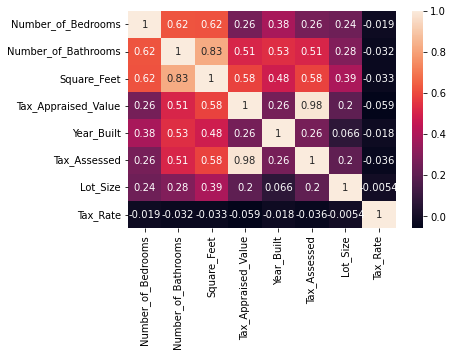

In [18]:
sns.heatmap(train.corr(),annot=True)
# in all three counties, highest correlation bewtween number of bedrooms to number of bathrooms and square feet, 
# square feet correlated to tax appraised value

In [29]:
LA = train[train.County == 'Los Angeles']
Orange = train[train.County == "Orange"]
Ventura = train[train.County == 'Ventura']
# ability to explore each county

In [30]:
train.County.value_counts(normalize=True)
# 66% of homes are in LA county

Los Angeles    0.661716
Orange         0.265006
Ventura        0.073278
Name: County, dtype: float64

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Homes on Zillow by County')

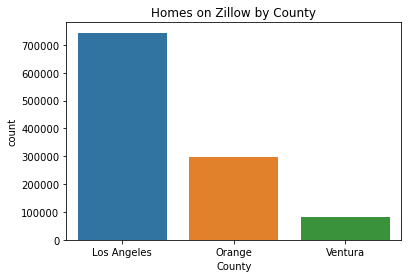

In [31]:
sns.countplot(train.County)
plt.title('Homes on Zillow by County')

<AxesSubplot:>

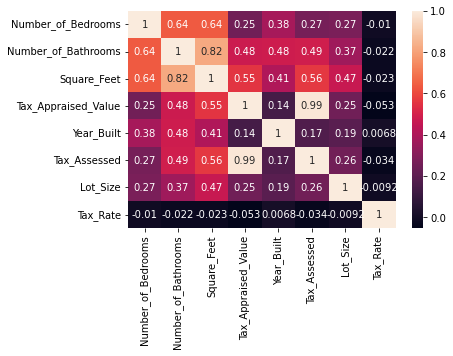

In [32]:
sns.heatmap(LA.corr(),annot=True)
#  LA county's highest correlation to tax appraisal is square feet (outside of tax ammount)

<AxesSubplot:>

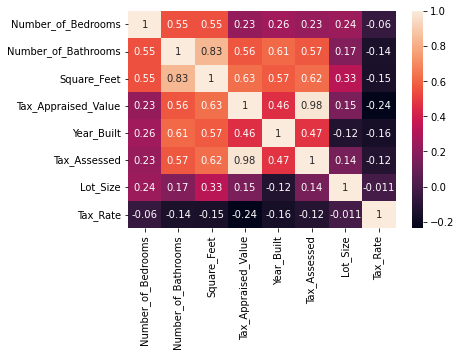

In [23]:
sns.heatmap(Orange.corr(),annot=True)
# Orange county's highest coorelation to tax appraisal is square feet (outside of tax ammount)

<AxesSubplot:>

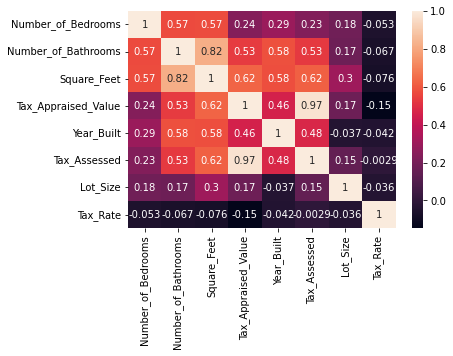

In [24]:
sns.heatmap(Ventura.corr(),annot=True)
# Ventura county's highest coorelation to tax appraisal is square feet (outside of tax ammount)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


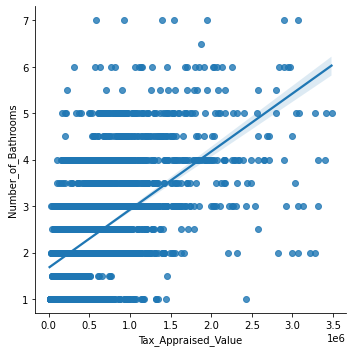

In [25]:
sns.lmplot('Tax_Appraised_Value','Number_of_Bathrooms', data=train.sample(10000), scatter=True, hue=None, col=None)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


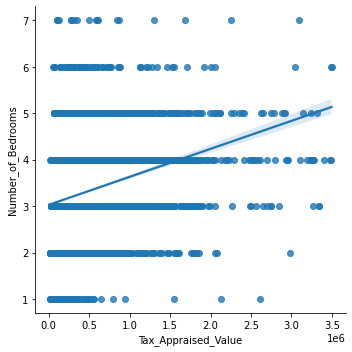

In [26]:
sns.lmplot('Tax_Appraised_Value','Number_of_Bedrooms', data=train.sample(10000), scatter=True, hue=None, col=None)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


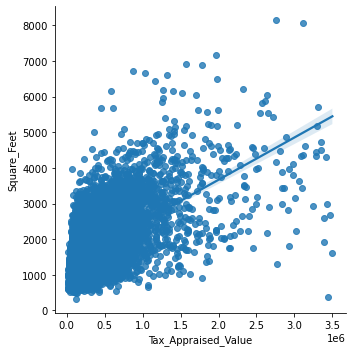

In [27]:
sns.lmplot('Tax_Appraised_Value','Square_Feet', data=train.sample(10000), scatter=True, hue=None, col=None)

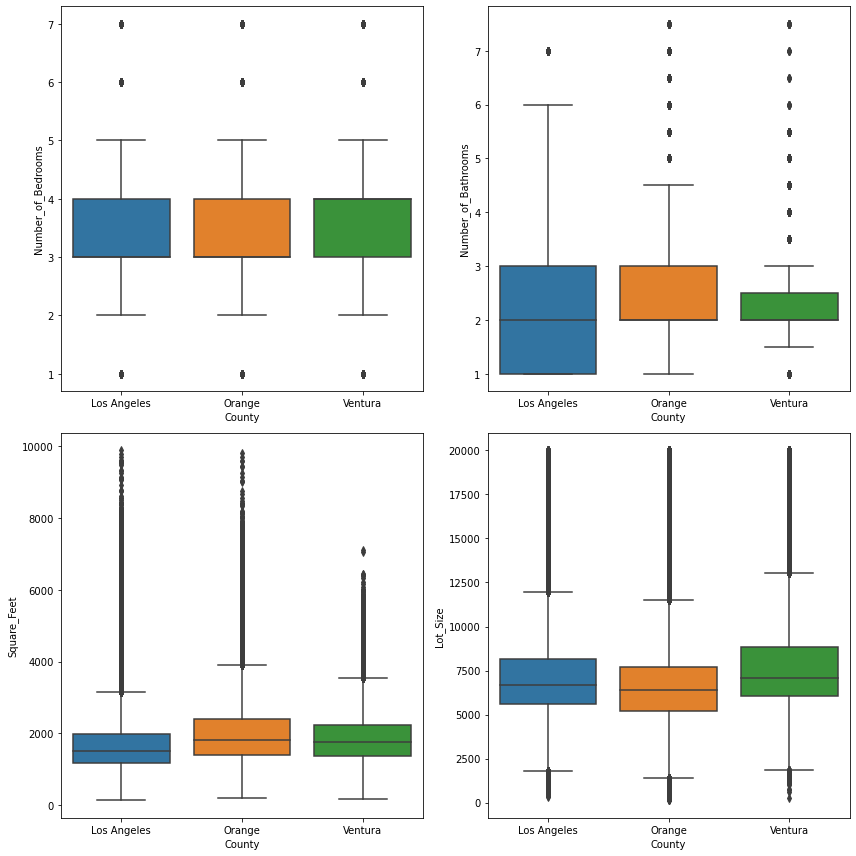

In [52]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Number_of_Bedrooms)
plt.subplot(2,2,2)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Number_of_Bathrooms)
plt.subplot(2,2,3)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Square_Feet)
plt.subplot(2,2,4)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Lot_Size)
plt.tight_layout()
plt.show()

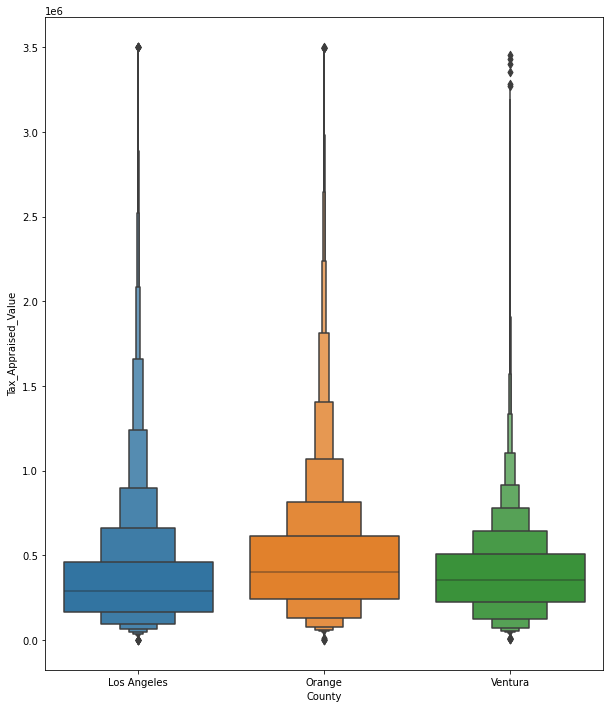

In [65]:
plt.figure(figsize=(10,12))
sns.boxenplot(data=train, y=train.Tax_Appraised_Value, x=train.County)
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
plt.suptitle('Tax Rates by County (per $ of Assessed Value)', fontsize=14)

plt.subplot(331)
sns.lineplot(LA['Tax_Rate'])
plt.title('Los Angeles County')

plt.subplot(332)
sns.displot(Orange['Tax_Rate'])
plt.title('Orange County')

plt.subplot(333)
sns.displot(Ventura['Tax_Rate'])
plt.title('Ventura County')
plt.show()

### Evaluate

In [ ]:
X_train = train.drop(columns ='Tax_Appraised_Value','Tax_Assessed')
y_train = train_scaled['Tax_Appraised_Value']

X_validate = validate.drop(columns ='Tax_Appraised_Value','Tax_Assessed')
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns ='Tax_Appraised_Value','Tax_Assessed')
y_test = test['Tax_Appraised_Value']